In [1]:
import numpy as np
import pandas as pd
from ast import literal_eval
%matplotlib inline
import matplotlib.pyplot as plt

# add root to path
import sys
sys.path.append("/Users/jeffreycheng/dev/improve_muon")

from empirical.research.make_singular_values_gif import _fit_alpha_beta, _local_gaps_from_singulars

In [2]:
df = pd.read_csv("~/dev/improve_muon/research_logs/singular_values_distribution/test_run/cache/step_45.csv")
df['means'] = df['means'].apply(lambda x: literal_eval(x))
df['stds'] = df['stds'].apply(lambda x: literal_eval(x))

In [3]:
df

,param_type,layer_num,means,stds,tau,alpha,beta
0,Attention Q,10,"[0.0015353638445958495, 0.00043031733366660774...","[9.582042548572645e-05, 8.607705967733636e-05,...",1.092480e-09,0.017806,1.156829e-17
1,Attention V,9,"[0.005771901924163103, 0.0010124151594936848, ...","[0.0003081057220697403, 4.442026329343207e-05,...",8.159698e-10,0.016407,6.894296e-18
2,MLP Output,11,"[0.01801024191081524, 0.0036098684649914503, 0...","[0.0007643472054041922, 0.00021283661772031337...",0.000000e+00,0.033432,0.000000e+00
3,Attention O,14,"[0.013269361108541489, 0.0030860700644552708, ...","[0.0007095800247043371, 0.0005502129788510501,...",3.239053e-10,0.019173,1.497578e-17
4,MLP Input,5,"[0.008681126870214939, 0.0030367793515324593, ...","[0.00021959417790640146, 9.245044930139557e-05...",0.000000e+00,0.024540,0.000000e+00
...,...,...,...,...,...,...,...
87,MLP Input,1,"[0.018768310546875, 0.00797358900308609, 0.005...","[0.0003350380575284362, 0.00020910020975861698...",0.000000e+00,0.024540,0.000000e+00
88,Attention O,6,"[0.0068349880166351795, 0.0019388056825846434,...","[0.00021739878866355866, 0.0002077448880299925...",5.844724e-10,0.019173,1.497578e-17
89,MLP Output,4,"[0.04524029791355133, 0.009743059985339642, 0....","[0.001219082623720169, 0.0004633672069758177, ...",0.000000e+00,0.033432,0.000000e+00
90,Attention Q,8,"[0.0020380723290145397, 0.0004946485278196633,...","[9.436527034267783e-05, 0.00021072366507723927...",1.090279e-09,0.017806,1.156829e-17


In [4]:
import pandas as pd

# sanity: paired list lengths match
if not (df['means'].str.len() == df['stds'].str.len()).all():
    bad = df.index[(df['means'].str.len() != df['stds'].str.len())].tolist()
    raise ValueError(f"mismatched means/stds lengths in rows: {bad}")

# deterministic within-type ordering
df2 = df.sort_values(['param_type', 'layer_num'])

# {param_type -> DataFrame(mean, std, layer_num)}
result = {}
for pt, g in df2.groupby('param_type', sort=False):
    out = (
        g[['layer_num', 'means', 'stds']]
        .rename(columns={'means': 'mean', 'stds': 'std'})
        .explode(['mean', 'std'], ignore_index=True)     # explode within each layer
        [['mean', 'std', 'layer_num']]
    )
    # ensure numeric dtypes
    out['mean'] = out['mean'].astype(float)
    out['std']  = out['std'].astype(float)
    result[pt] = out

# example: result['Attention Q'].head()


In [5]:
attnk = result['Attention K']
mean = attnk.loc[attnk['layer_num'] == 0, 'mean']
sorted_mean = attnk.loc[attnk['layer_num'] == 0, :].sort_values(by='mean')['mean']
(mean - sorted_mean).sum()

np.float64(0.0)

In [16]:
import numpy as np
from scipy.optimize import least_squares

def fit_alpha_beta_qprk(x, y, g, iters: int = 200):
    """
    Fit the model
        y^2 ≈ [ (α x^q)^{2κ} + (β x^r / g^p)^{2κ} ]^{1/κ}
    by minimizing
        Σ [ log(y_i^2) - (1/κ) log( exp(κ A_i) + exp(κ B_i) ) ]^2
    where A_i = 2( log α + q log x_i ),
          B_i = 2( log β + r log x_i - p log g_i ).

    Returns (alpha, beta, q, p, r, kappa).
    - Setting r=0 and kappa=1 recovers your previous α,β,q,p model.
    - r > 0 gives a slight positive slope in the left tail.
    - kappa controls how sharp the transition is between branches.
    """
    x = np.asarray(x); y = np.asarray(y); g = np.asarray(g)
    m = (x > 0) & (y > 0) & (g > 0) & np.isfinite(x) & np.isfinite(y) & np.isfinite(g)
    x = x[m]; y = y[m]; g = g[m]
    if x.size < 3:
        return float("nan"), float("nan"), 1.0, 1.0, 0.0, 1.0

    lnx = np.log(x); lng = np.log(g); Z2 = 2.0 * np.log(y)

    # ---- inits ----
    # q: slope on high-x tail
    q0 = 1.0
    hi = lnx >= np.quantile(lnx, 0.7)
    if hi.sum() >= 3:
        A = np.vstack([np.ones(hi.sum()), lnx[hi]]).T
        coef, *_ = np.linalg.lstsq(A, 2.0*np.log(y[hi]), rcond=None)  # Z2 ≈ a + b*lnx
        q0 = float(np.clip(0.5 * coef[1], 1e-3, 3.0))

    # small left-tail slope on gap branch
    r0 = 0.10

    alpha0 = np.median(y[hi] / (x[hi]**q0)) if hi.sum() >= 3 else float(np.mean(y / (x**q0)))
    alpha0 = max(alpha0, 1e-12)

    p0 = 1.0
    lo = lnx <= np.quantile(lnx, 0.3)
    beta0 = np.median(y[lo] * (g[lo]**p0) / (x[lo]**r0)) if lo.sum() >= 3 else float(np.mean(y * (g**p0) / (x**r0)))
    beta0 = max(beta0, 1e-12)

    kappa0 = 1.0  # 1 = quadratic sum; larger = sharper corner

    # log-parameterization for positivity
    theta0 = np.array([
        np.log(alpha0),  # loga
        np.log(beta0),   # logb
        np.log(max(q0, 1e-6)),   # logq
        np.log(max(p0, 1e-6)),   # logp
        np.log(max(r0, 1e-6)),   # logr
        np.log(max(kappa0, 1e-6))  # logk
    ], dtype=float)

    # bounds (wide but sane)
    lb = np.array([-50, -50, np.log(1e-6), np.log(1e-6), np.log(1e-6), np.log(0.25)], dtype=float)
    ub = np.array([+50, +50, np.log(1e+3), np.log(1e+3), np.log(1e+3), np.log(8.0)], dtype=float)

    def residuals(theta):
        loga, logb, logq, logp, logr, logk = theta
        q = np.exp(logq); p = np.exp(logp); r = np.exp(logr); kappa = np.exp(logk)
        A = 2.0 * (loga + q*lnx)
        B = 2.0 * (logb + r*lnx - p*lng)
        # power-mean / softmax with temperature kappa
        F = (1.0 / kappa) * np.logaddexp(kappa * A, kappa * B)
        return Z2 - F

    res = least_squares(residuals, theta0, bounds=(lb, ub), max_nfev=iters, method="trf")
    loga, logb, logq, logp, logr, logk = res.x
    return float(np.exp(loga)), float(np.exp(logb)), float(np.exp(logq)), float(np.exp(logp)), float(np.exp(logr)), float(np.exp(logk))


def predict_std_qprk(x, g, alpha, beta, q, p, r, kappa):
    """Predict std from the fitted params."""
    x = np.asarray(x); g = np.asarray(g)
    lnx = np.log(x); lng = np.log(g)
    A = 2.0 * (np.log(alpha) + q*lnx)
    B = 2.0 * (np.log(beta) + r*lnx - p*lng)
    F = (1.0 / kappa) * np.logaddexp(kappa * A, kappa * B)
    return np.exp(0.5 * F)


In [26]:
def visualize_noise_model(df, title):
    # One figure across layers; log axes; avoid SettingWithCopy
    fig, ax = plt.subplots()
    layers = sorted(df['layer_num'].unique())
    denom = max(1, max(layers))  # for colormap normalization

    for layer_num in layers:
        g = df.loc[df['layer_num'] == layer_num, :].copy()
        # sort DESC so gaps correspond to local spacing in the spectrum
        g = g.sort_values('mean', ascending=False).reset_index(drop=True)

        # arrays + positivity mask
        x = g['mean'].to_numpy()
        y = g['std'].to_numpy()
        m = (x > 0) & (y > 0) & np.isfinite(x) & np.isfinite(y)
        x = x[m]; y = y[m]
        if x.size < 3:
            continue

        gap = _local_gaps_from_singulars(x)

        # fit
        
        alpha, beta, q, p, r, k = fit_alpha_beta_qprk(x=x, y=y, g=gap)
        print(layer_num, alpha, beta, q, p, r, k)

        # predict on the same x/gap, then sort x for a clean line
        yhat = predict_std_qprk(x, gap, alpha=alpha, beta=beta, q=q, p=p, r=r, kappa=k)
        order = np.argsort(x)  # ascending for plotting a smooth curve

        color = plt.cm.viridis(layer_num / denom)
        ax.scatter(x, y, color=color, alpha=0.25, s=12)
        ax.plot(x[order], yhat[order], color=color, linewidth=1.0, alpha=0.5)

    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel('Mean singular value')
    ax.set_ylabel('Std of singular value')
    # ax.grid(True, which='both', alpha=0.3)
    ax.set_title(title)
    plt.show()


def visualize_gap(df):
    for layer_num in df['layer_num'].unique():
        layer_df = df.loc[df['layer_num'] == layer_num, :]
        layer_df['gap'] = _local_gaps_from_singulars(layer_df['mean'])
        plt.scatter(
            x=layer_df['mean'].apply(np.log),
            y=layer_df['gap'].apply(np.log),
            color=plt.cm.viridis(layer_num / 15),
            alpha=0.2
        )

0 1.7408250403705108 6.001818302043263e-07 1.535380510023312 0.051929842080633296 0.20068710924593974 0.508053641886128
1 1.070860922556042 5.2033313386821885e-08 1.4739095522213232 1.0036092691026384e-06 1.0001470998510638e-06 0.2710721626417319
2 2.1274055513248564 1.2096810084221258e-06 1.580943625055543 1.0120974742417027e-06 0.22288483212844562 0.2697922623770557
3 0.9588010490562984 5.644906468071777e-10 1.3954038162362852 0.15553893851064318 0.011406852667364117 0.2500000000004336
4 0.4745040160466684 1.040770235854198e-06 1.3034773125914099 0.05988012814185866 0.3536286670737709 0.7181394489851316
5 0.9950935967494278 2.3102017388603267e-08 1.3860660496887254 1.0020424767700673e-06 0.08065390413406798 0.35733790403858195
6 0.7428924339976547 5.261541568570148e-10 1.3437847645076642 0.16582804232264817 0.05824471262898392 0.33377650333973474
8 2.306842504299067 5.803963716255266e-08 1.444715059311924 1.037334324205275e-06 0.2019316082774287 0.25000000000000006
9 0.65864051437710

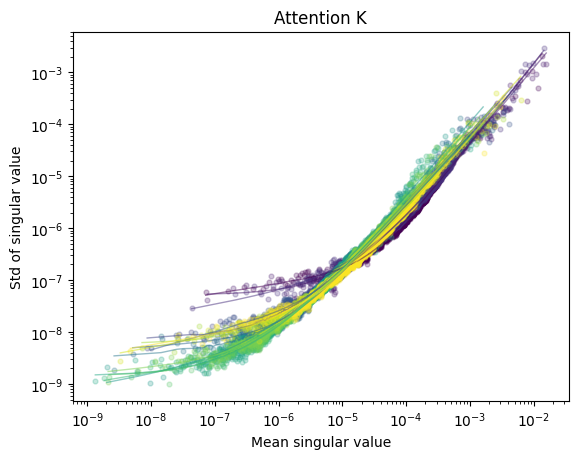

0 0.4650763591046935 8.02995000350661e-08 1.4113161565143422 0.058137726657301325 0.031169182496647598 0.40355034429463965
1 0.36312081107751926 7.70452405275355e-06 1.3658965563279652 1.005768015146841e-06 0.3161333703974112 1.4535533612480431
2 0.25760817200695696 2.15807774267552e-06 1.3140252461094208 1.0026051844667227e-06 0.25246005581307734 0.8538214716538277
3 0.21272095919271997 6.071456019684626e-08 1.2537549149625566 1.0001499155759552e-06 0.11096043241346895 0.5245387929866712
4 0.1610897394189279 3.4393794204929016e-07 1.2048598379594546 1.0000222296856363e-06 0.21970458409503835 1.998018599351795
5 0.24440875323311004 4.256205594679252e-07 1.2358578442549866 1.000226312989914e-06 0.2601290543023438 1.4219423587475952
6 0.2053903308662797 9.390014900114307e-08 1.2158649137282755 1.0000288141745899e-06 0.17263932681325772 0.8832373294786822
8 0.20745176298760504 3.096023882490067e-09 1.1978335883110618 0.13609721663465882 0.15663124729872605 1.115521402473464
9 0.2031922120

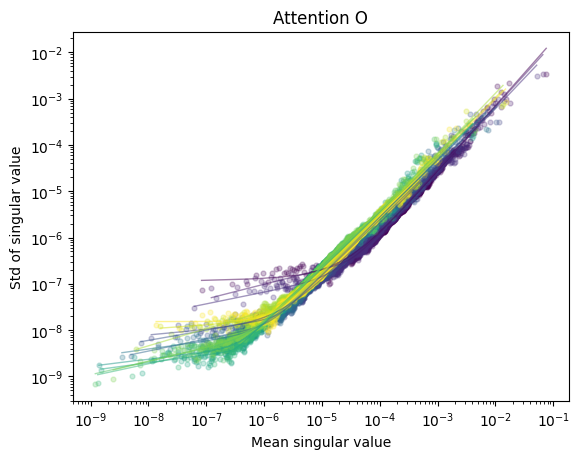

0 3.433052443038983 9.286114413348087e-10 1.6362296560180283 0.4687980218906616 0.25454873134112094 0.2870378159315259
1 1.6726499930677645 1.8209305419346929e-07 1.5278821030060035 0.1796314615682439 0.268556277862958 0.4789688857605773
2 1.802000723221975 3.0937171065068907e-10 1.5520250109481672 0.3463156567575268 0.049296613513354605 0.2500000000079303
3 0.9950915248047764 9.939570365439175e-09 1.4008841372154697 1.0106293978429517e-06 0.004992641366464234 0.26328549947402013
4 0.6226102848846304 1.171564396445391e-10 1.3333960166596266 0.23756002444714103 1.0000601080830023e-06 0.3698988665881478
5 0.5394961475503898 4.9291575285991744e-08 1.3239478219590037 1.191565456505057e-06 0.131478337827653 0.4629469431982639
6 0.6928421043548002 1.7035259117202325e-09 1.3457832769165143 0.05083096366759445 0.023447168852928624 0.25000000000048933
8 0.6210317910575401 2.389353857086532e-08 1.301349310818633 1.0029145252642578e-06 0.14792543590034238 0.3728400351854091
9 0.8820143411540293 1

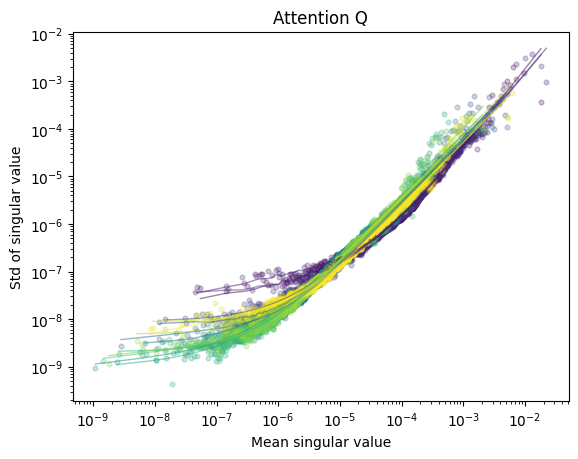

0 0.538552465153191 7.402393263465648e-07 1.3419824681042092 1.0000026385713896e-06 0.22170048860331715 1.2879519924260219
1 0.378222485666374 8.69167898479019e-07 1.3044095333292136 1.0334437803774797e-06 0.24252286064423478 1.0528568906610138
2 0.28409033499957276 6.0391250558853815e-09 1.2823319283385268 0.18898905957825338 0.1421721610712738 7.999999999999597
3 0.2196043821201132 3.808668126702404e-08 1.255985181680184 1.0009771307154573e-06 0.08063037703654292 0.87353938442617
4 0.25535595068501976 1.5398562918737334e-07 1.2589104834819411 1.0002912364717096e-06 0.17913535081716772 1.859124528231453
5 0.26426059641383015 1.549154216322419e-07 1.243496638331492 0.11383610571158881 0.3379052759032618 2.4229540446783884
6 0.2748902218989086 7.601435320018138e-09 1.2521841737338448 1.0009925165943158e-06 0.027775643194988767 0.84703596865391
8 0.3421083663355362 1.5834188426041957e-07 1.2538427156097351 0.016683588064833544 0.267005926177272 4.437683010536237
9 0.28165501234454043 2.6

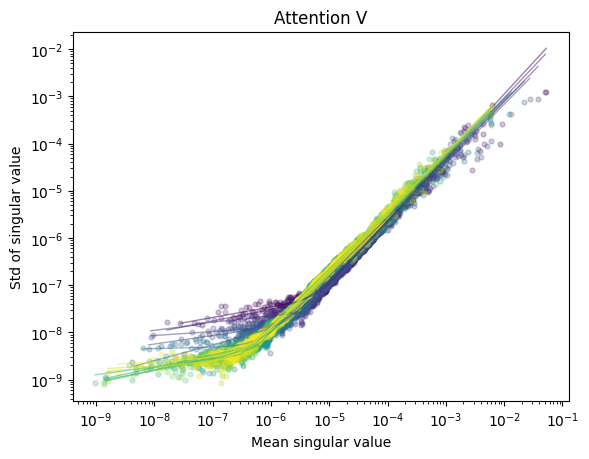

0 1.05292735235092 5.938941246683961e-20 1.4106553595486484 1.0090995972908801e-06 378.2344070029885 6.5578746896749704
1 0.3124322402030479 1.202095575439349e-07 1.2730445524674725 0.1151611308124142 0.4704733043185188 2.8695671940711223
2 0.21975339494420865 2.9088490568266387e-19 1.2354454661664196 0.15266015158241944 0.3598825793926812 2.0917737850718723
3 0.20994000770865692 3.929826919850503e-11 1.225858112980686 0.01072001222632951 2.1146416474200507 4.419617391857644
4 0.19773375081849448 2.0142626919507624e-22 1.2134393973328426 0.020745839155314336 986.5319185093234 4.51164063958537
5 0.1566225178164841 3.4532505298688565e-19 1.1855909743030215 0.021332767723788445 1.4106465456041455 7.999518442080072
6 0.2109290828555282 4.738237761685224e-21 1.2081027373761282 0.021906151198496187 0.00017631781346866753 1.6752090794192702
7 0.19762029033665932 1.5763383339040545e-15 1.1875434692755475 0.25432031927643545 1.2713307177588018 0.25085809430071443
8 0.233781304606733 2.017302729

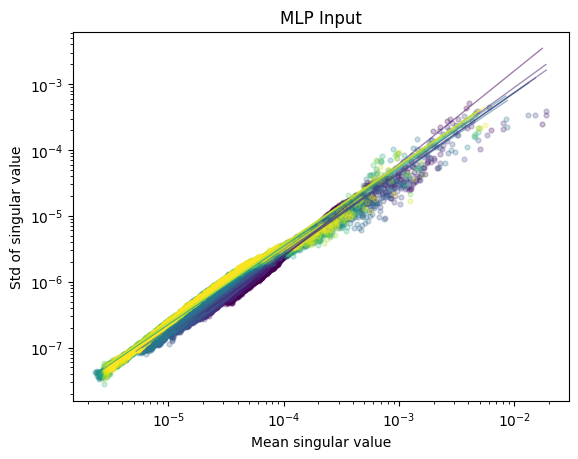

0 0.5314946019481673 6.431989108388792e-20 1.3478098685174391 0.00046900052282013675 6.93934823697852 0.7781797780643008
1 0.3914730205136762 1.1438939602578544e-21 1.296587954776928 1.1008365237797948e-06 932.2629971398428 3.7853958319940415
2 0.2585136236723715 3.7379069945441436e-09 1.2342615139031434 0.01102999419748886 26.413115190762845 0.4325759715106762
3 0.23618933129283998 1.879218259506497e-11 1.2170218085349869 0.19589251117201217 0.3089971085253788 1.2510151221536279
4 0.25719844378386675 1.9519942404890514e-22 1.2210670488251851 1.0649933012222283e-06 958.8313062340613 0.6592734519357832
5 0.2872799538945988 0.0010321524308245014 1.2280817742325876 0.007697643926258447 2.7285299618546444 7.999811695705773
6 0.29147809584470563 2.027229803057746e-05 1.2228880672297977 0.015020306119857166 1.7630099298557962 1.6137969457006158
7 0.3620064774812765 4.854972856017068e-07 1.2292866242065728 0.02903258529758173 1.1403878541248216 7.99999997336891
8 0.42982998794025823 7.1483905

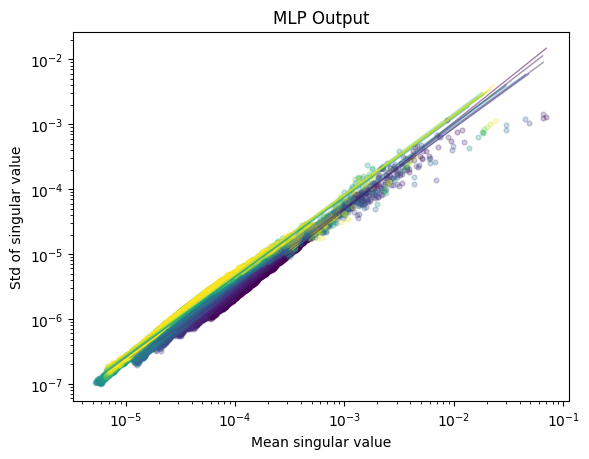

In [27]:
for key in result:
    visualize_noise_model(result[key], key)

/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_56930/700770587.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['gap'] = _local_gaps_from_singulars(layer_df['mean'])
/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_56930/700770587.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  layer_df['gap'] = _local_gaps_from_singulars(layer_df['mean'])
/var/folders/j_/gtf27dt106j4lt576pm77g_40000gn/T/ipykernel_56930/700770587.py:46: SettingWithCopyWarning: 
A value is trying to be

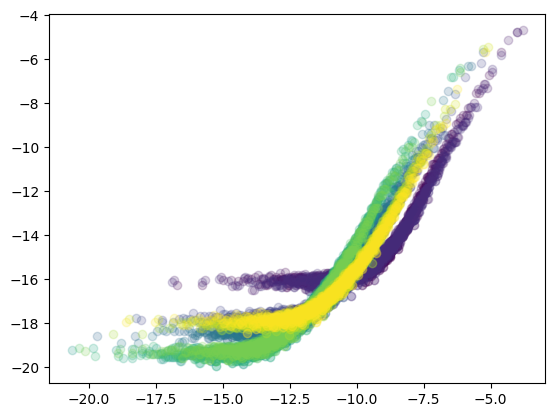

In [28]:
visualize_gap(result['Attention Q'])

In [44]:
def visualize_optimal_h(df, title):
    for layer_num in df['layer_num'].unique():
        layer_df = df.loc[df['layer_num'] == layer_num, :]
        plt.scatter(
            x=layer_df['mean'],
            y=layer_df.apply(lambda row: row['mean'] ** 3 / (row['mean'] ** 2 + row['std'] ** 2), axis=1),
            color=plt.cm.viridis(layer_num / 15),
            alpha=0.2,
        )
    plt.xscale('log')
    plt.ylim(0, 1)
    plt.title(title)
    plt.show()

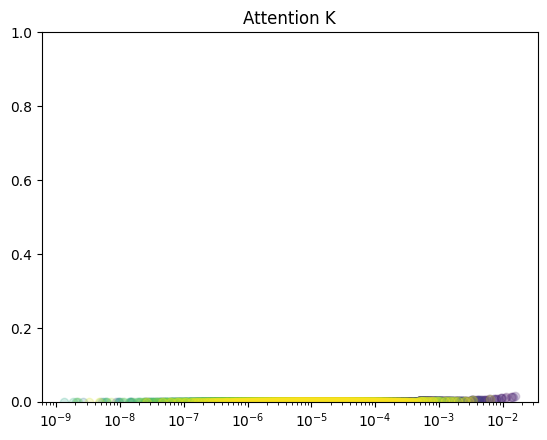

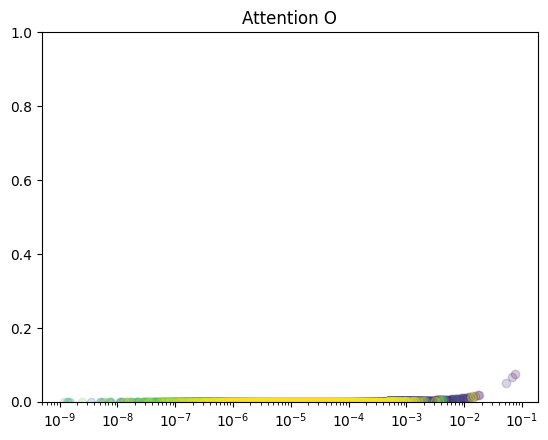

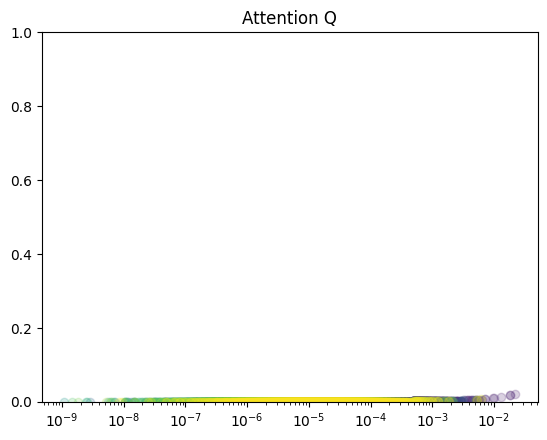

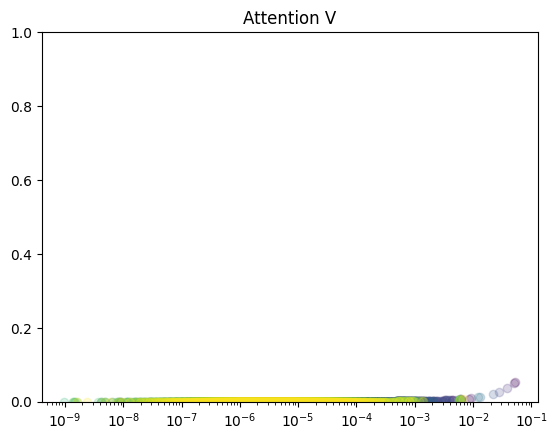

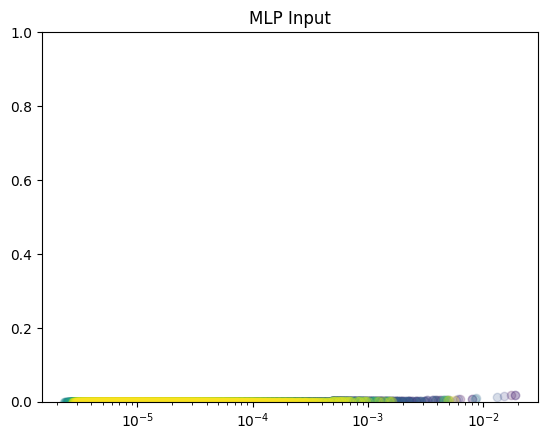

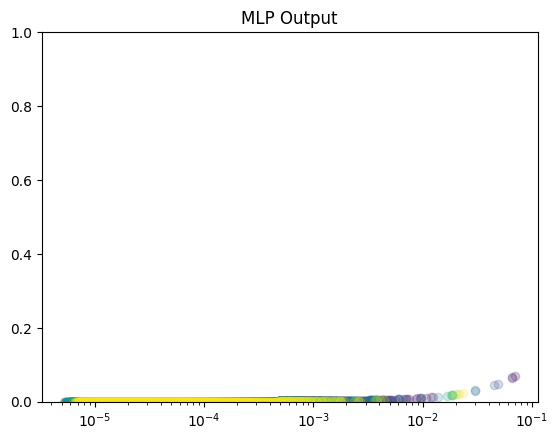

In [45]:
for key in result:
    visualize_optimal_h(result[key], key)